<a href="https://colab.research.google.com/github/ggonz105/MAT-421/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Analysis of Logistic Regression as a Means for Loan Approvals**
Richard Lowther and Gabriel Gonzales, MAT 421

### **Introduction and Related Work**

Loan companies use different attributes of a customer to determine whether or not they are approved to receive a loan. These companies use industry-standard variables, including the customer’s debt-to-income ratio (DTI ratio), income, credit score, employment history, etc. These requests are then either approved or denied, which thus necessitates a binary classification method. If a loan company were to provide too many “bad” loans quickly, it could jeopardize the company and possibly cause bankruptcy.


If a bank were to dispense too many bad loans, it could result in the bank having more debts than assets, rendering the bank insolvent and incapable of repaying its depositors and tarnishing its reputation. Additionally, banks providing bad loans in excess can strongly impact the economy and are a proven marker to indicate when economic crises occur.a1 According to Fredriksson and Frykström,a1 “Bad loans also risk impairing long-term economic growth and lead to greater uncertainty in the banking system which results in elevated financial stability risks.”

Because of the financial importance of providing proper loans, mathematical models have been developed to more accurately predict whether or not the customer meets the adequate requirements to receive a loan. Logistic regression is a machine learning algorithm that, in this scenario, can be given the customer’s credentials and will provide a probability of the loan being approved or rejected.

Multiple machine learning models can provide similar answers to the given data. Logistic regression is regarded as a simpler machine learning model than what Lina3 used in their research, such as XGBoost, an enhanced version of a Gradient Boosting Decision Tree, Random Forest, and AdaBoost. These models are more advanced than logistic regression due to their implementation of decision trees to more accurately provide the probability of loan approval. However, highly sophisticated models require more time and development due to their complex nature. This raises the question of whether or not companies can omit the necessity of developing such intricate algorithms by utilizing a simpler model.

Hai and Ngoc$^{a4}$ used logistic regression in their study of 1,000 loan applicants and achieved an accuracy of 76.80%. Similarly, Lin found that standard logistic regression had an accuracy of 81.06% as compared to the previously mentioned complex methods that reached accuracies in the lower 90% range. These accuracies were based on a database that had 32,581 entries. The data used in this project will contain 252,000 entries before being parsed, which should produce higher accuracies than what the previous authors had achieved. Because of the accessibility of such a large dataset, this project aims to determine if utilizing a significantly larger dataset could compensate for a simpler machine learning model.


### **Dataset and Math Method**

The dataset chosen for the project was the Loan Approval Dataset compiled by Rohit Sharma. The dataset contains information for each 252,000 loan applicants on their income, age, years of professional experience, marital status, whether or not they own or rent a house, car ownership, job occupation, city and state of residence, duration of their current employment, duration of the residence of their home, and whether they were flagged as a loan risk. However, after reviewing the data, it was found that about 80% of the data were not unique entries, leaving the dataset with only 43,190 unique entries. This is still about 30% larger than the database that Lin used, and should still be able to answer the research question.

The mathematical method chosen for this project is binary multiple logistic regression, which is similar to linear regression. However, linear regression requires a linear relationship between the independent and dependent variables as opposed to logistic regression. Binary logistic regression operates on some assumptions: the dependent variable–loan approval in this scenario–must be binary, each observation must be independent from one another, and the independent variables should not be too highly correlated with each other.$^{a5}$ If all of these assumptions are met, the dataset will be able to produce a high-accuracy algorithm with little issues.

In [ ]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_json('/content/drive/My Drive/loan_approval_dataset.json')

# Check if any rows without their ID numbers are duplicates of eachother, False = Unique
noID_df = df.drop(columns=['Id'])
duplicate_rows = noID_df.duplicated()
duplicate_counts = duplicate_rows.value_counts()
print(duplicate_counts)

# Remove any duplicate rows after the first occurrence
df = noID_df.drop_duplicates()

Mounted at /content/drive
True     208810
False     43190
Name: count, dtype: int64


In [ ]:
#Determine if there are any missing values in the data (0 is good!)
df.isnull().sum()

,0
Income,0
Age,0
Experience,0
Married/Single,0
House_Ownership,0
Car_Ownership,0
Profession,0
CITY,0
STATE,0
CURRENT_JOB_YRS,0


### **Data Distributions**

This section was aimed to provide a visualization of the data after it was processed. About 20% of the loan applicants were flagged as a loan risk, which did pose a risk of the data set being too imbalanced in the favor of non-risk loans. This may inflate the accuracy if the algorithm were to focus more on non-risk applicants.

The distribution of age, income, current home ownership, and years of experience had no significant spike in values and were evenly distributed. About 12% of the population was married as opposed to being single, the large majority (about 90%) of applicants rented their home rather than owned or neither, and 30% of the applicants owned a car. The years working for the current job peaked at around 3 years and linearly tapered off until 14 years.

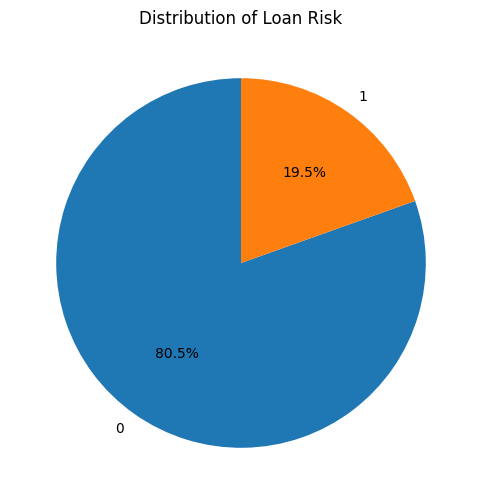

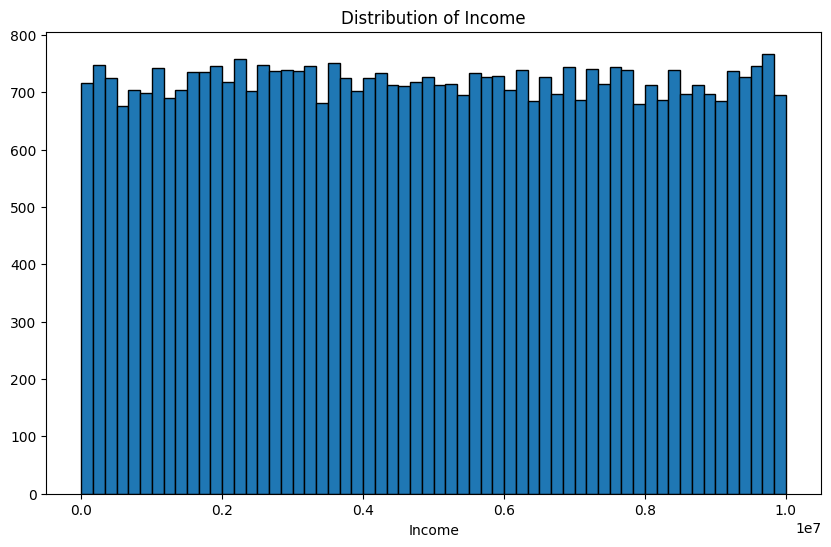

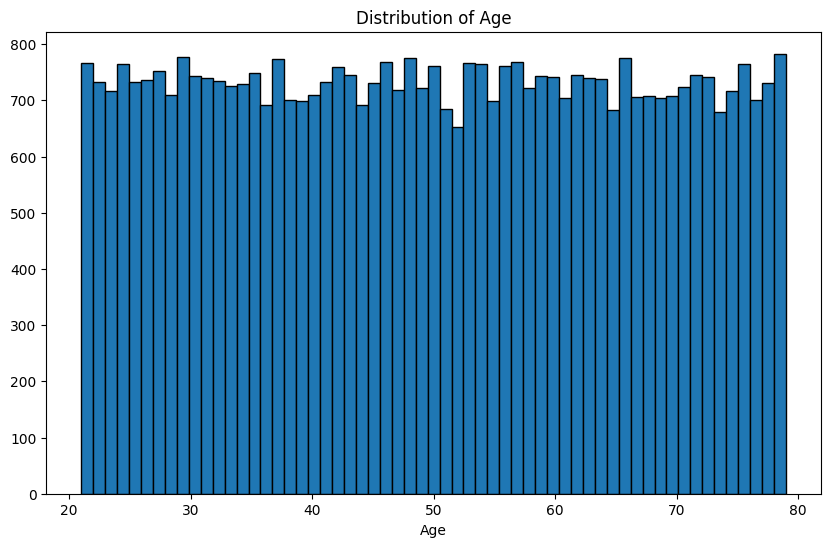

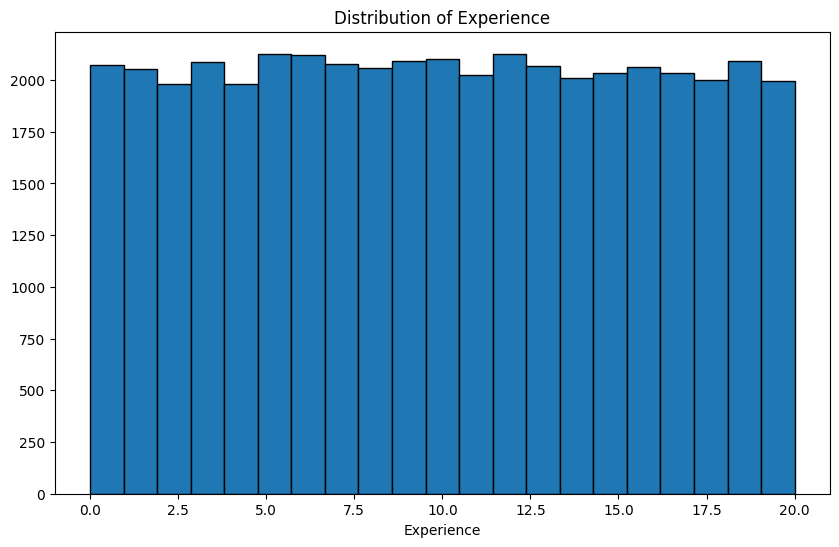

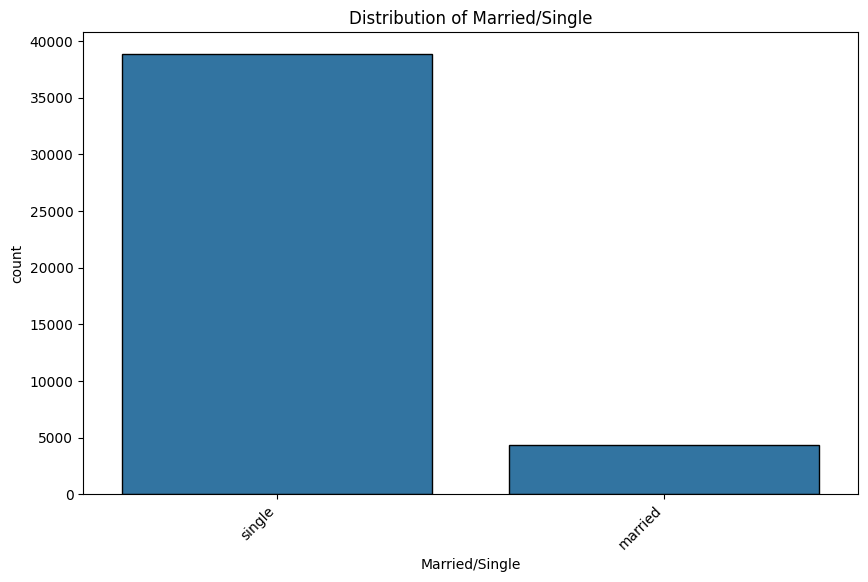

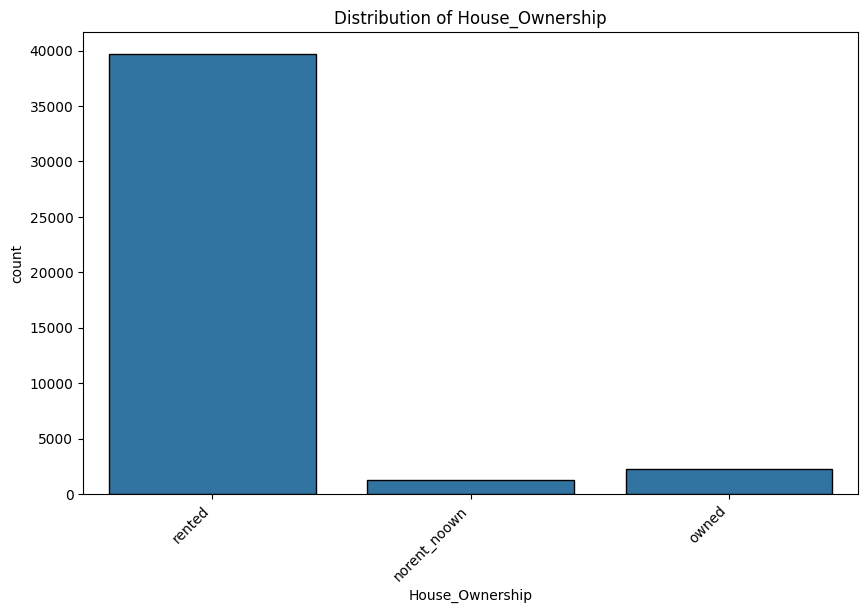

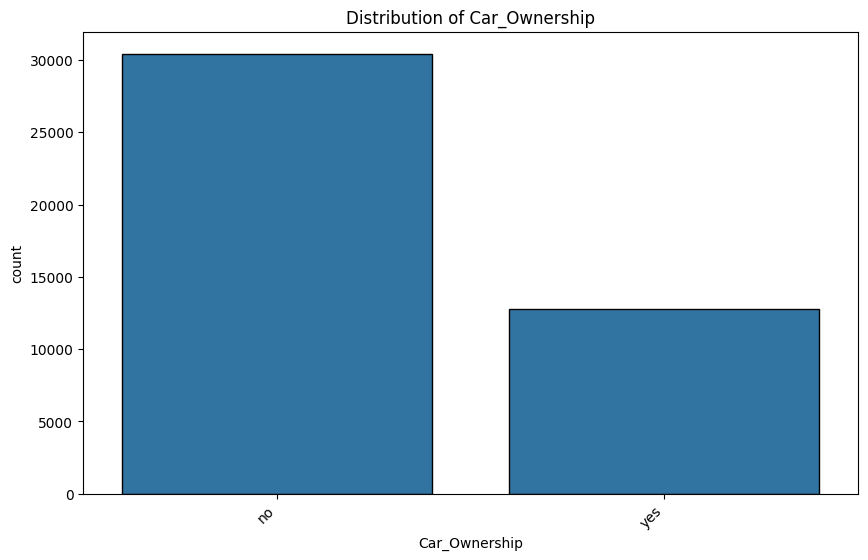

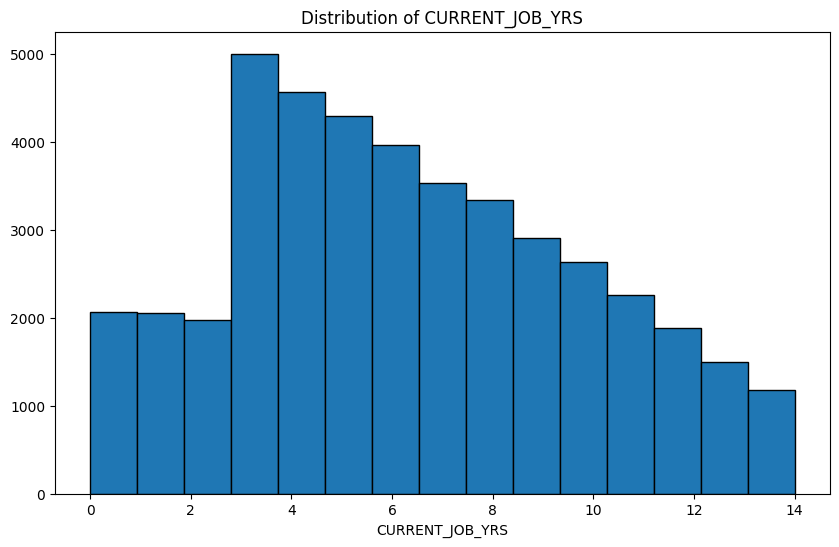

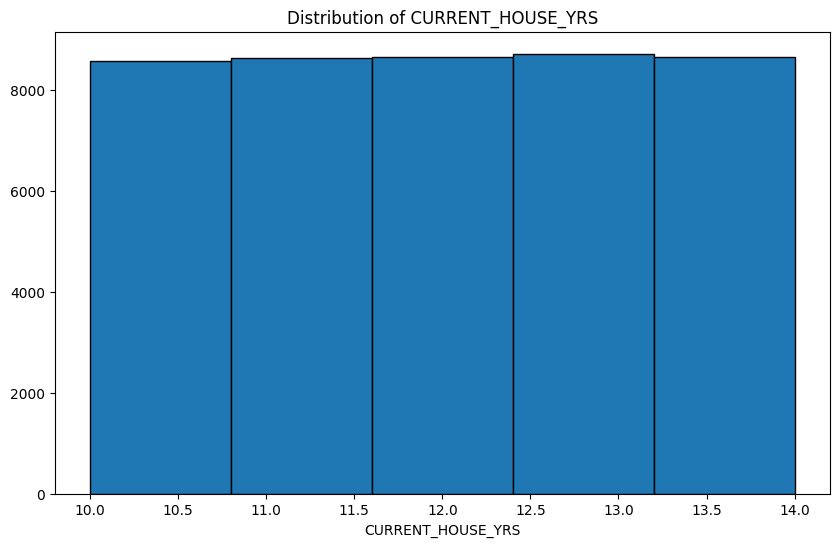

In [ ]:
# Loan Risk Count (1 = flagged as a risk)
risk_counts = df['Risk_Flag'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Loan Risk')
plt.show()

features = ['Income', 'Age', 'Experience', 'Married/Single', 'House_Ownership', 'Car_Ownership', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
for feature in features:
    # Categorical feature
    if df[feature].dtype == 'object':
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x=feature, data=df, edgecolor='black')
        plt.title(f'Distribution of {feature}')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed

        plt.show()
    # Numerical feature
    else:
        plt.figure(figsize=(10, 6))

        # Calculate the range of numerical values
        data_range = int(df[feature].max() - df[feature].min() + 1)

        # Limit the number of bins if it's too large
        max_bins = 60
        num_bins = min(data_range, max_bins)

        plt.hist(df[feature], bins=num_bins, edgecolor='black')
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)

### **Implementation**

**Feature Engineering and Encoding**

Feature selection focused on the relevant financial and demographic indicators that were expected to influence loan risk. The specific features selected from the dataset were an individual's income, age, experience, marital status, house ownership, car ownership, current job years, and current house years. Since we are dealing with machine learning, the categorical features (marital status, house ownership, and car ownership) must be transformed into a numerical format. This was accomplished using one-hot encoding which converts the category values into binary vectors. The "drop_first=True" command was used to ensure that we prevent multicollinearity. The processed dataset was then partitioned into both training and testing sets, while maintaining an 80-20 split to facilitate both model training and unbiased evaluation

**Model Training and Evaluation**

A logistic regression model was selected due to the binary nature of the target variable of risk. Recognizing the potential class imbalance highlighted during the exploratory analysis, the model was configured with a variable, class_weight='balanced.' This configuration will allow the model to appropriately penalize the majority class, while also improving the minority class prediction. Due to the extensive amount of data points present and to ensure model convergence, the max amount of iterations has been set to 10,000.

After training the model, predictions were then generated on the test set, with the performance of the model being assessed using an accuracy score and a detailed classification report. The classification report consisted of precision values, recall values, and F1-score metrics for both classes.

**Statistical Analysis**

A Logit model was fit using the "statsmodels" library to implement the scikit-learn-based logistic regression. This allowed for a more detailed statistical interpretation of the predictors' impact. With fitting the Logit model, a comprehensive summary report including coefficient estimates, p-values, confidence intervals, and goodness-of-fit statistics was produced.

In [ ]:
!pip install statsmodels
import statsmodels.api as sm

# Select features and target variable

target = 'Risk_Flag'

# Create a DataFrame with selected features and target
data = df[features + [target]]

# One-hot encode categorical features
categorical_features = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession']
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=[target]), data[target], test_size=0.2, random_state=13)

# Make sure in X_train and X_test are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce').astype(float)
X_test = X_test.apply(pd.to_numeric, errors='coerce').astype(float)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=10000, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
report = classification_report(y_test, y_pred, zero_division=1)
print(f"Classification Report:\n{report}")

# Add a constant to the features (required for statsmodels)
X_train = sm.add_constant(X_train) # This line was previously run before one-hot encoding. Moving it here fixes the error

# Fit the Logit Regression model using statsmodels
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Print the results summary
print(result.summary())


Accuracy: 0.5519796249131743
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.58      0.68      7000
           1       0.19      0.42      0.26      1638

    accuracy                           0.55      8638
   macro avg       0.50      0.50      0.47      8638
weighted avg       0.69      0.55      0.60      8638

Optimization terminated successfully.
         Current function value: 0.495306
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Risk_Flag   No. Observations:                34552
Model:                          Logit   Df Residuals:                    34492
Method:                           MLE   Df Model:                           59
Date:                Sun, 27 Apr 2025   Pseudo R-squ.:                0.001689
Time:                        05:22:11   Log-Likelihood:                -17114.
converged:                       True   LL-Nu

### **Results**

The logistic regression model trained on the loan approval dataset achieved an accuracy of approximately 55% on the test set. This indicates that the model correctly classified slightly more than half of the applicants regarding their loan risk status, making it slightly better than a coin flip. However, a closer examination of the classification report reveals important nuances about the model's performance across different classes.

When looking at the non-risky loan cases (class 0), it can be seen that the model achieved a relatively high precision value of 0.81. This means that the model correctly predicted a loan to be classified as non-risky 81% of the time. However, when looking at the recall value for these cases, the model can be seen struggling to identify a considerable portion of the non-risky loans, by achieving a recall value of only 0.58. With an F1-score for this class being 0.68, the model would be considered an average predictive model for the non-risky loan classification.

Conversely, for the risky loans (class 1), the model’s performance was significantly worse achieving precision and recall values of 0.19 and 0.42 respectively, resulting in an F1-score of 0.26. This low F1-score indicates the model’s weak ability to correctly identify and predict the risky cases, while only capturing a small amount of the risky cases. The incredibly low precision value shows the model’s high rate of false positives captured in this class, which leads to many low-risk applicants being incorrectly flagged as high-risk.

The overall macro-averaged precision and recall values were both 0.50, with the macro-averaged F1-score being 0.47. This reflects the model’s difficulty in balancing performance across both classes. The weighted averages, which take class imbalance into account, were slightly better, with a weighted F1-score of 0.60. However, these metrics still confirm that the model is incredibly limited in its ability to distinguish between risky and non-risky applicants.

To contextualize these results, a comparison was made with the study by Hai and Ngoc$^{a4}$ where they applied a logistic regression model to a German credit dataset and achieved a 73% accuracy. This accuracy shows that their model significantly outperforms our current model, and this is due to their more in depth approach. Their approach involved extensive feature engineering, which included the selection of statistically significant variables based on p-values, and the rebalancing of categorical variables to improve the prediction reliability.

Differences in the dataset could also contribute to the large performance gap, as our dataset dealt with 80% non-risky vs 20% risky and their dataset dealt with 70% good loans vs 30% bad loans. While balanced class weights were used in the current model to address this, they could be insufficient to fully correct for the skewed distribution.

Although the logistic regression model established a basic predictive framework for loan applicants with a 55% accuracy, its low precision for identifying risky loans indicates that more sophisticated modeling techniques or additional feature engineering may be necessary to achieve greater reliability and practical utility in real-world loan risk assessment scenarios. This is seen by the methodological differences, such as optimizing the decision threshold in the study by Hai and Ngoc to better separate classes, highlighting a potential improvement for any future iterations of this model.


### **Conclusion**

This project explored the use of a logistic regression model to predict loan risk using a large, but highly redundant, loan approval dataset. Despite applying standard preprocessing techniques such as one-hot encoding and class balancing, the logistic regression model achieved a modest accuracy of approximately 55%. While the model was able to reasonably predict non-risky loans, it struggled significantly with accurately identifying risky applicants–a critical weakness for any real-world loan approval system.

The results highlight several key insights within our model’s performance compared to other models. Even though our dataset is significantly larger than the one used in the Hai and Nogc’s model, their model had superior performance compared to ours. If the data lacks sufficient variability or if important predictive features are missing or underrepresented, the large dataset will not guarantee higher model performance. Although logistic regression provides a simple and interpretable framework for binary classification, it may not capture complex patterns within the data as effectively as more advanced machine learning models. This study also reaffirms the importance of going through extensive feature engineering, thorough dataset balancing, and potential threshold optimization to achieve a higher performing model.

Ultimately, while logistic regression provided a useful starting point, the findings suggest that achieving practical and reliable predications for loan risk likely requires either the enhancement of feature selection techniques, the adoption of more complex algorithms like ensemble methods, or both. Future work could focus on incorporating feature importance analyses, engineering new predictive variables, and experimenting with more sophisticated models such as XGBoost or Random Forests to improve the accuracy and robustness of loan risk predictions.


### **References**

a1) Fredriksson, O., & Frykström, N. (2019, November 2). How bad loans affect banks and financial stability. Sveriges Riksbank. https://www.riksbank.se/en-gb/press-and-published/notices-and-press-releases/notices/2019/how-bad-loans-affect-banks-and-financial-stability/

a3) Lin, J. (2024). Research on loan default prediction based on logistic regression, randomforest, xgboost and adaboost. SHS Web of Conferences, 181, 02008. https://doi.org/10.1051/shsconf/202418102008

a4) Hai, H. T., & Ngoc, D. T. H. (2020, May). Application Of Logistic Regression Model In Consumer Loans Credit Scoring. International Journal of Advanced Research and Publications.

a2) Sharma, R. (2024, April 20). Loan approval dataset. Kaggle. https://www.kaggle.com/datasets/rohit265/loan-approval-dataset?resource=download

a5) Intellectus Consulting. (2024, December 31). Assumptions of logistic regression. Statistics Solutions. https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/assumptions-of-logistic-regression/#:~:text=First%2C%20binary%20logistic%20regression%20requires,be%20independent%20of%20each%20other.
